In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from tensorflow.contrib import predictor

/data/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
sys.path.insert(0, '/Data/repos/zoobot')
from zoobot.tfrecord import catalog_to_tfrecord

### What's the Problem?

Given a galaxy image, we want to know if the galaxy is 'smooth' or featured.

We have a set of crowdsourced answers. Each galaxy has about 40 responses. 

Let's aim to predict the crowd majority vote.

### Look at the crowd labels

Load all crowd answers. How common is each response?

In [89]:
columns_to_save = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'smooth-or-featured_total-votes',
    'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_featured-or-disk_fraction',
    'smooth-or-featured_smooth_min',
    'smooth-or-featured_smooth_max',
    'smooth-or-featured_featured-or-disk_min',
    'smooth-or-featured_featured-or-disk_max',
    'smooth-or-featured_prediction-encoded',  # 0 for artifact, 1 for featured, 2 for smooth
    'classifications_count',
    'subject_id',
    'nsa_id',
    'ra',
    'dec']

df_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s28_l0.5_test.tfrecord.csv'
df = pd.read_csv(df_loc, usecols=columns_to_save + ['fits_loc', 'png_loc', 'png_ready'], dtype={'fits_loc': str})

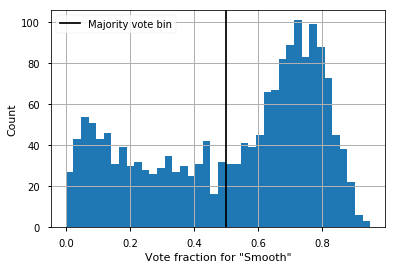

In [90]:
fraction_col = 'smooth-or-featured_smooth_fraction'
df['label'] = df[fraction_col] > 0.5
ax = df[fraction_col].hist(bins=40)
ax.axvline(0.5, c='k')
plt.xlabel('Vote fraction for "Smooth"')
plt.ylabel('Count')
plt.legend(['Majority vote bin'])

In [84]:
print(df['smooth-or-featured_prediction-encoded'].value_counts())
print(df[fraction_col].mean())

2    1127
1     639
Name: smooth-or-featured_prediction-encoded, dtype: int64
0.5157122938000258


In [91]:
print(df['smooth-or-featured_smooth_fraction'].mean())
print(df['smooth-or-featured_featured-or-disk_fraction'].mean())

0.5157122938000258
0.3616220082306222


The crowd somewhat separates 'smooth' from 'featured' galaxies, but there's clearly a continuum. 

Let's start with the binary case (what would the majority say) and then move on to regression (what fraction would say 'smooth).

In [92]:
'Fraction of galaxies which the crowd thinks are smooth: {:.2f}%'.format(np.mean((df[fraction_col] < 0.5).astype(float)))

'Fraction of galaxies which the crowd thinks are smooth: 0.41%'

Smooth galaxies are a little less common than featured galaxies - bear this in mind when looking at accuracy. A dumb majority class classifier would get 60% accuracy.

### Train Bayesian CNN

See https://github.com/RustyPanda/zoobot/tree/master/zoobot

Training is done on .tfrecord files after a simple 80/20 train/test split.

### Load saved models at untrained, mid-training and trained stages

In [110]:
untrained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k/1526576403'  # needs update
midtrained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k/1526576403' 
trained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k/1526581573' 

untrained_model_unwrapped = predictor.from_saved_model(untrained_model_loc)
midtrained_model_unwrapped = predictor.from_saved_model(midtrained_model_loc)
trained_model_unwrapped = predictor.from_saved_model(trained_model_loc)

# wrap to avoid having to pass around dicts all the time
untrained_model = lambda x: 1 - untrained_model_unwrapped({'examples': x})['all_predictions']
midtrained_model = lambda x: 1 - midtrained_model_unwrapped({'examples': x})['all_predictions']
trained_model = lambda x: 1 - trained_model_unwrapped({'examples': x})['all_predictions']

models = [untrained_model, midtrained_model, trained_model]

INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k/1526576403/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k/1526576403/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k/1526581573/variables/variables'


## How accurate are the model samples on test data?

In [111]:
n_examples = 50
samples_per_example = 1000

### Load the the test catalog (galaxy labels)

In [112]:
test_df = pd.read_csv('/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5_test.tfrecord.csv', usecols=[fraction_col])
example_data = test_df[:n_examples]  # index will match tfrecord examples

### Load serialized galaxy examples

In [113]:
def load_examples_from_tfrecord(tfrecord_loc, n_examples):
    with tf.Session() as sess:
        feature = {'matrix': tf.FixedLenFeature([], tf.float64),
                   'label': tf.FixedLenFeature([], tf.int64)}

        # Create a list of filenames and pass it to a queue
        filename_queue = tf.train.string_input_producer([tfrecord_loc], num_epochs=1)
        # Define a reader and read the next record
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        # Initialize all global and local variables
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        # Create a coordinator and run all QueueRunner objects
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        # execute
        return [sess.run(serialized_example) for n in range(n_examples)]


In [114]:
tfrecord_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5_test.tfrecord'
examples = load_examples_from_tfrecord(tfrecord_loc, n_examples)

### Make model predictions

In [115]:
def get_samples_of_examples(model, examples, samples_per_example):
    results_store = []
    for nth_run in range(int(samples_per_example / 10)):
        results_store.append(model(examples))
    return np.concatenate(results_store, axis=1)

In [116]:
all_model_results = np.array([get_samples_of_examples(model, examples, samples_per_example) for model in models])
# dimensions [model, example, sample]
mean_model_results = np.mean(all_model_results, axis=2) # averaged over all samples

In [117]:
print(mean_model_results.shape)

(3, 50)


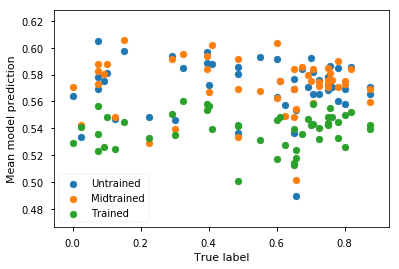

In [118]:
for model_n in range(len(models)):
    plt.scatter(example_data[fraction_col], mean_model_results[model_n])
plt.xlabel('True label')
plt.ylabel('Mean model prediction')
plt.legend(['Untrained', 'Midtrained', 'Trained'])

Not looking like great...

### What do the sample distributions of the trained model look like?

In [119]:
def are_labels_correct(results, fractions):
    correct_labels = fractions > 0.5
    predicted_labels = pd.Series(np.mean(results, axis=1)) > 0.5
    return correct_labels == predicted_labels

In [120]:
print(are_labels_correct(all_model_results[0], example_data[fraction_col]).mean())

0.58


In [123]:
def compare_uncertainty_of_samples(results, example_data):
    correct = are_labels_correct(results, example_data[fraction_col])
    fig, axes = plt.subplots(len(example_data), figsize=(4, n_examples), sharex=True, sharey=True)
    for galaxy_n, ax in enumerate(axes):
        ax.hist(results[galaxy_n, :])
        c='r'
        if correct[galaxy_n]:
            c='g'
        ax.axvline(example_data.iloc[galaxy_n][fraction_col], c=c)

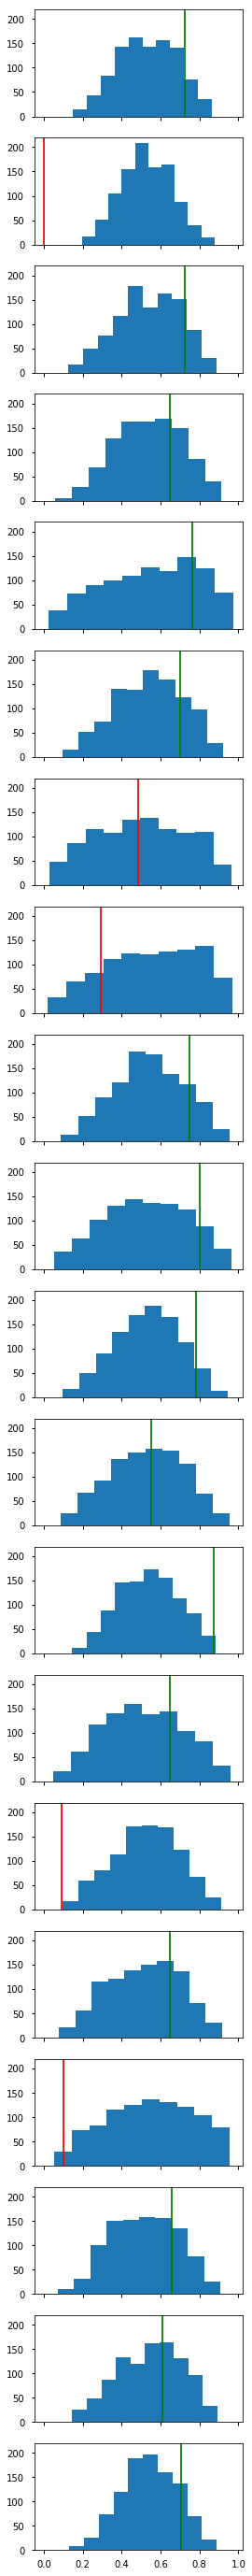

In [124]:
compare_uncertainty_of_samples(all_model_results[2, :20, :], example_data[:20])

In [110]:
def serialise_row(row):
    return catalog_to_tfrecord.row_to_serialized_example(
        row,
        img_size=64,
        label_col='smooth-or-featured_prediction-encoded',
        columns_to_save=columns_to_save,
        source='fits')

In [138]:
export_dir = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526556444'
model_4k = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526556444/variables/variables'


In [139]:
def many_predictions(predict_fn, df, samples, galaxies):
    galaxies_to_predict = df[:galaxies + 1].apply(serialise_row, axis=1)
    scores = np.zeros((samples, galaxies))
    for galaxy_n in range(galaxies):
        for n in range(samples):
            scores[n, galaxy_n] = predict_fn({'examples': galaxies_to_predict})['featured_score'][0]
    return scores

In [140]:
model_4k_predictions = many_predictions(model_4k, df, samples=250, galaxies=20)

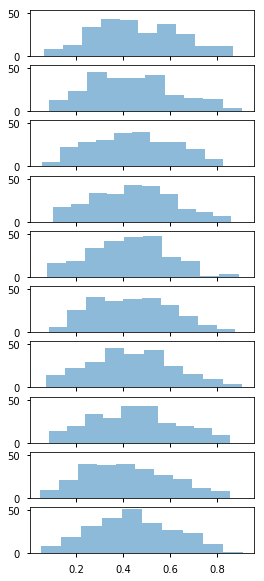

In [141]:
fig, axes = plt.subplots(galaxies, figsize=(4, 10), sharex=True, sharey=True)
for galaxy_n, ax in enumerate(axes):
    _ = ax.hist(np.array(model_4k_predictions[:, galaxy_n]), alpha=0.5)

In [224]:
export_dir = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526571631'
model_24k = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526571631/variables/variables'


In [225]:
model_24k_predictions = many_predictions(model_24k, df, samples=250, galaxies=20)

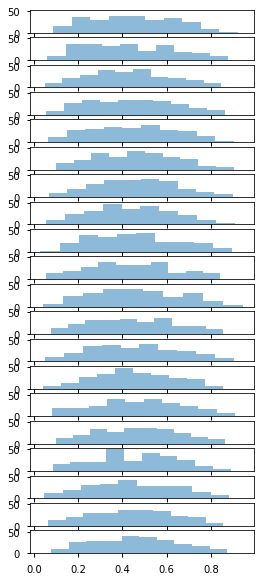

In [226]:
fig, axes = plt.subplots(galaxies, figsize=(4, 10), sharex=True, sharey=True)
for galaxy_n, ax in enumerate(axes):
    _ = ax.hist(np.array(model_9k_predictions[:, galaxy_n]), alpha=0.5)

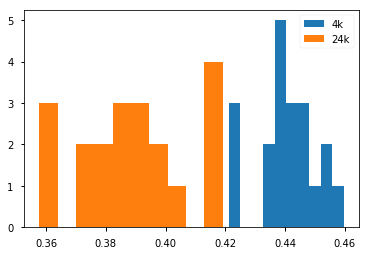

In [229]:
model_24k_predictions_mean = np.mean(model_24k_predictions, axis=0)
model_4k_predictions_mean = np.mean(model_4k_predictions, axis=0)
plt.hist(model_4k_predictions_mean)
plt.hist(model_24k_predictions_mean)
plt.legend(['4k', '24k'])

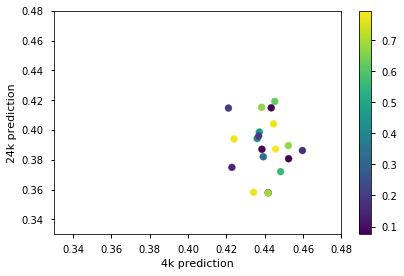

In [237]:
cmap = plt.cm.get_cmap()
ax = plt.scatter(model_4k_predictions_mean, model_24k_predictions_mean, c=df[:20][fraction_col])
plt.xlabel('4k prediction')
plt.ylabel('24k prediction')
plt.xlim([0.33, 0.48])
plt.ylim([0.33, 0.48])
plt.colorbar()
plt.tight_layout()

# cm = plt.cm.get_cmap('RdYlBu')
# xy = range(20)
# z = xy
# sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
# plt.colorbar(sc)
# plt.show()

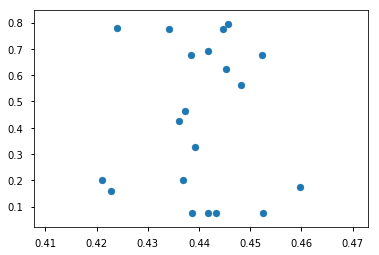

In [239]:
plt.scatter(model_4k_predictions_mean, df[:20][fraction_col])

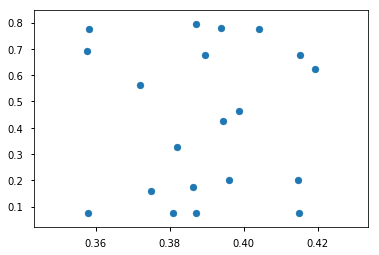

In [240]:
plt.scatter(model_24k_predictions_mean, df[:20][fraction_col])

In [178]:
predictors = []
for n in range(1, 10):
    predictors.append(predictor.from_saved_model(export_dir, signature_def_key='sample_{}'.format(n)))

INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5/1526560281/variables/variables'

In [218]:
galaxies = 20
galaxies_to_predict = df[:galaxies]
serialised_galaxies = galaxies_to_predict.apply(serialise_row, axis=1)

In [219]:
scores = np.zeros((len(galaxies_to_predict), len(predictors)))
for galaxy in range(len(galaxies_to_predict)):
    for predictor in range(len(predictors)):
        scores[galaxy, predictor] = predictors[predictor]({'examples': serialised_galaxies})['featured_score'][0]

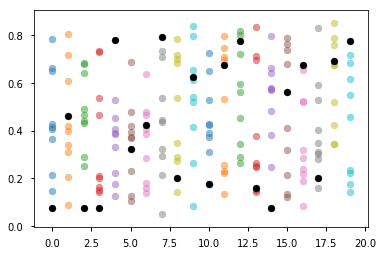

In [220]:
for n in range(len(galaxies_to_predict)):
    plt.scatter(np.ones(len(predictors)) * n, scores[n, :], alpha=0.5)
    
which_gal = []
gal_true_vf = []
for gal_n, gal in galaxies_to_predict.iterrows():
    which_gal.append(gal_n)
    gal_true_vf.append(gal[fraction_col])
plt.scatter(which_gal, gal_true_vf, c='k')

In [221]:
model_predictions = many_predictions(model_9k, df, samples=1, galaxies=1000)

In [ ]:
mean = np.mean(model_predictions, axis=0)
print(mean)

0.3952434881087203